# Global energy consumption and reliability on consumable fuels​

## Authors
- Darko Bashukoski
- Kristijan Pucoski
- Nikola Simjanovski
- Edin Tufek

## Imports

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from collections import Counter
import geopandas

## Organizing and Filtering Data
To get started we had to organize our data in a way that would enable us to efficienty and quickly work with it. As it had 122 attributes, we needed to select which ones we would use, so we selected around 20 of the most useful ones. The data set also contained rows for areas like `Europe`, `World`, etc. This did not make sense as they were not countries, but totals of multiple countries. We decided to remove them as they would cause a problem because they would be duplicate data. We also decided to only use data that was after the year 1965 as there was a lot of missing data for previous years. The last thing we did was separate the data into multiple tables to get a better separation of attributes that were not related to each other.

In [6]:
def replaceEmptyValue(value):
    return 0 if value == '' else value

rawData = csv.DictReader(open('Data/WorldEnergyConsumption.csv', 'rt', encoding='utf-8'))
consumptionFile = open('Data/ConsumptionData', 'w', newline='', encoding='utf-8')
productionFile = open('Data/ProductionData', 'w', newline='', encoding='utf-8')
populationFile = open('Data/PopulationData', 'w', newline='', encoding='utf-8')

consumptionWriter = csv.writer(consumptionFile)
productionWriter = csv.writer(productionFile)
populationWriter = csv.writer(populationFile)

fuelTypes = ["biofuel", "coal", "fossil", "gas", "hydro", "low_carbon", "nuclear", "oil", "solar", "wind"]
ignore = ["World", "Europe", "Middle East", "Africa", "Eastern Africa", "Middle Africa",
          "Western Africa", "Asia Pacific", "Central America", "North America", "South & Central America"]

consumptionWriter.writerow(["country", "year"] + fuelTypes)
productionWriter.writerow(["country", "year"] + fuelTypes)
populationWriter.writerow(["country", "year", "population"])
countries = set()

for row in rawData:
    if row["country"] in ignore or int(row["year"]) < 1965 or int(row["year"]) == 2020:
        continue
    
    consumptionRow = []
    productionRow = []
    populationRow = []
    
    countries.add(row["country"])
    
    for key in ["country", "year"] + [x+"_consumption" for x in fuelTypes]:
        consumptionRow.append(replaceEmptyValue(row[key]))
    
    for key in ["country", "year"] + [x+"_electricity" for x in fuelTypes]:
        productionRow.append(replaceEmptyValue(row[key]))
        
    for key in ["country", "year", "population"]:
        populationRow.append(replaceEmptyValue(row[key]))

    consumptionWriter.writerow(consumptionRow)
    productionWriter.writerow(productionRow)
    populationWriter.writerow(populationRow)

## Consumption per Country
The first thing we wanted to check was which countries consumed the most energy. We also wanted to know how much of the used energy came from consumable and how much from renewable sources. The results we got are presented it the form of a bar chart where the blue part of the bars is consumable fuels and the green is renewable. The country with the highest energy consumption is `China` and we also found that renewable fuels are used a shockingly low amount.

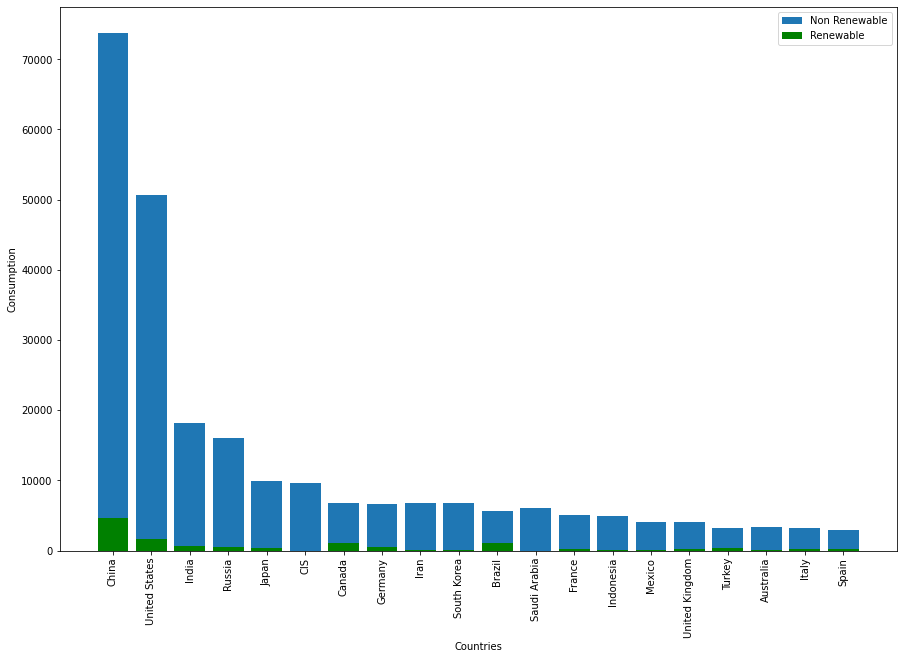

In [7]:
rawData = pd.read_csv('Data/ConsumptionData')
populationData = pd.read_csv('Data/PopulationData')
rawData1 = rawData.where(rawData["year"] == 2019).dropna()
population2019 = populationData.where(populationData["year"] == 2019).dropna()


renewable = ["hydro","solar","wind"]
nonrenewable =  ["biofuel", "coal", "fossil", "gas", "low_carbon", "nuclear", "oil"]

def sortDictionary(d,itemNum,rev=True):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[itemNum],reverse=rev)}

countryConsumption = {}
for r in list(rawData1["country"]):
    for x in fuelTypes:
        if r not in countryConsumption.keys():
            countryConsumption[r] = 0.0
        countryConsumption[r] += float(rawData1[rawData1["country"] == r][x])    
        
countryConsumptionSorted = sortDictionary(countryConsumption,1)  

renewableC = {}
nonrenewableC = {}
for r in countryConsumptionSorted:
    for x in renewable:
        if r not in renewableC.keys():
            renewableC[r] = 0.0
        renewableC[r] += float(rawData1[rawData1["country"] == r][x])  
    for x in nonrenewable:
        if r not in nonrenewableC.keys():
            nonrenewableC[r] = 0.0
        nonrenewableC[r] += float(rawData1[rawData1["country"] == r][x])
        
x = list(renewableC.keys())[:20]
non = list(nonrenewableC.values())[:20]
re = list(renewableC.values())[:20]

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.bar(x, non, label="Non Renewable")
ax.bar(x, re, color='g', label="Renewable")
ax.set_xlabel('Countries')
ax.set_ylabel('Consumption')
plt.xticks(rotation=90)
plt.legend()

plt.show();

Because there are hundreds of countries, it would not make sense to plot them all on the graph, so we used a map to get a better visualization of the data.

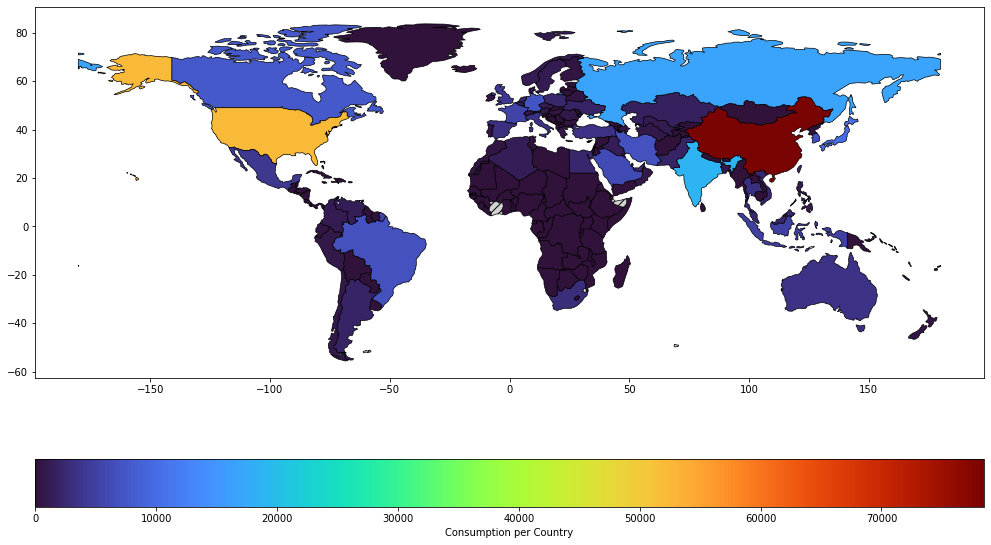

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
world['name'].mask(world['name'] == 'W. Sahara', 'Western Sahara', inplace=True)
world['name'].mask(world['name'] == 'United States of America', 'United States', inplace=True)
world['name'].mask(world['name'] == 'Macedonia', 'North Macedonia', inplace=True)
world['name'].mask(world['name'] == 'Bosnia and Herz.', 'Bosnia and Herzegovina', inplace=True)
world['name'].mask(world['name'] == 'S. Sudan', 'South Sudan', inplace=True)
world['name'].mask(world['name'] == 'Dem. Rep. Congo', 'Democratic Republic of Congo', inplace=True)
world['name'].mask(world['name'] == 'Central African Rep.', 'Central African Republic', inplace=True)
world['name'].mask(world['name'] == 'Eq. Guinea', 'Equatorial Guinea', inplace=True)
world['name'].mask(world['name'] == 'Solomon Is.', 'Solomon Islands', inplace=True)
world['name'].mask(world['name'] == 'Dominican Rep.', 'Dominican Republic', inplace=True)

def drawMap(d,text):
    mapData = pd.DataFrame.from_dict({"country":d.keys(),"usage":d.values()})
    mapTable = world.merge(mapData, how="left", left_on=['name'], right_on=['country'])

    fig, ax = plt.subplots(figsize=(17,10))
    mapTable.plot(ax=ax,column='usage',
              edgecolor="black", linewidth=0.7,
              cmap='turbo',
              legend=True,
              legend_kwds={'label': text, 'orientation': "horizontal"},
              missing_kwds={"color": "lightgrey", "label": "Missing values", "hatch": "///"});
    
drawMap(countryConsumptionSorted, "Consumption per Country")

## Consumption per population
It was unfair to compare consumption rates of countries with largly differing population numbers as naturally a country with a higher population is going to consume more power. To make sure that was the case we checked the correlation between populations and consumptios of each country and we got `0.775228` correlation coefficient. This meant that the population and consumption are closely related.

In [9]:
countryPopulation = {}
for r in list(population2019["country"]):
    if r not in countryPopulation.keys():
        countryPopulation[r] = 0
    countryPopulation[r] = int(population2019[population2019["country"] == r]["population"])
    
countryPopulationSorted = sortDictionary(countryPopulation,1)

correlation = np.corrcoef(list(countryConsumption.values()), list(countryPopulation.values()))
print("Correlation:\n")
print("%12s" %" ","%12s" %"Consumption", "%12s" %"Population")
print("%-12s" %"Consumption","%12f"%correlation[0][0],"%12f"%correlation[0][1])
print("%-12s" %"Population","%12f"%correlation[1][0],"%12f"%correlation[1][1])

Correlation:

              Consumption   Population
Consumption      1.000000     0.775262
Population       0.775262     1.000000


With such a high correlation we decided to divide the consumption of each country with the population count to get the consumption per person for each country.

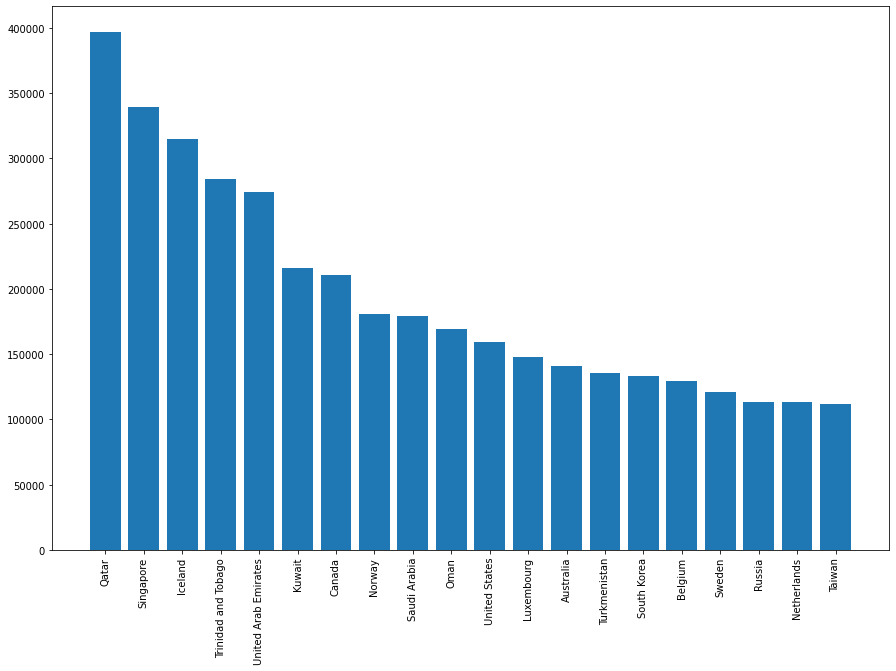

In [10]:
consumptionPerPopulation={}
for c,con in countryConsumptionSorted.items():
    consumptionPerPopulation[c] = 0.0
    for c1,pop in countryPopulationSorted.items():
        if c==c1:
            if pop!=0:
                consumptionPerPopulation[c] = round((con*1000000000)/pop,1)
            break
consumptionPerPopulation = sortDictionary(consumptionPerPopulation,1)

sortedCPP = {k:v for k,v in consumptionPerPopulation.items() if v!=0}
plt.figure(figsize=(15,10))
plt.bar(list(sortedCPP.keys())[:20], list(sortedCPP.values())[:20])
plt.xticks(rotation=90)
plt.show();

Again, similarly to the previous grpah, to get a better view of the results we plotted them on a map of the world.

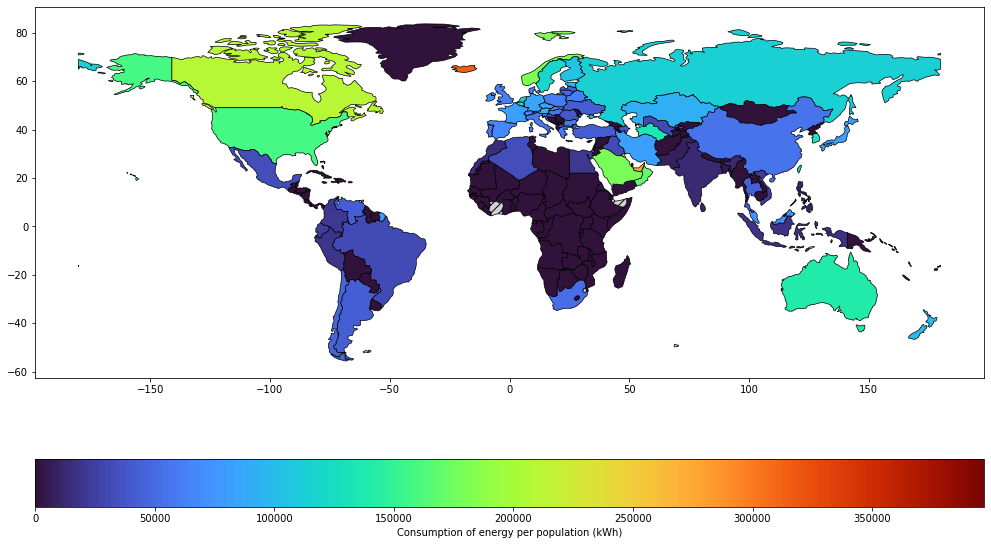

In [11]:
drawMap(consumptionPerPopulation,"Consumption of energy per population (kWh)")

## Energy consumprion over the years
The next thing we were interested in was the total energy consumprion for each year and how it increased over time. From the results we concluded that the consumption grew from `84006 tWh` to `321301 tWh` per year with a `2.5%` annual increase.

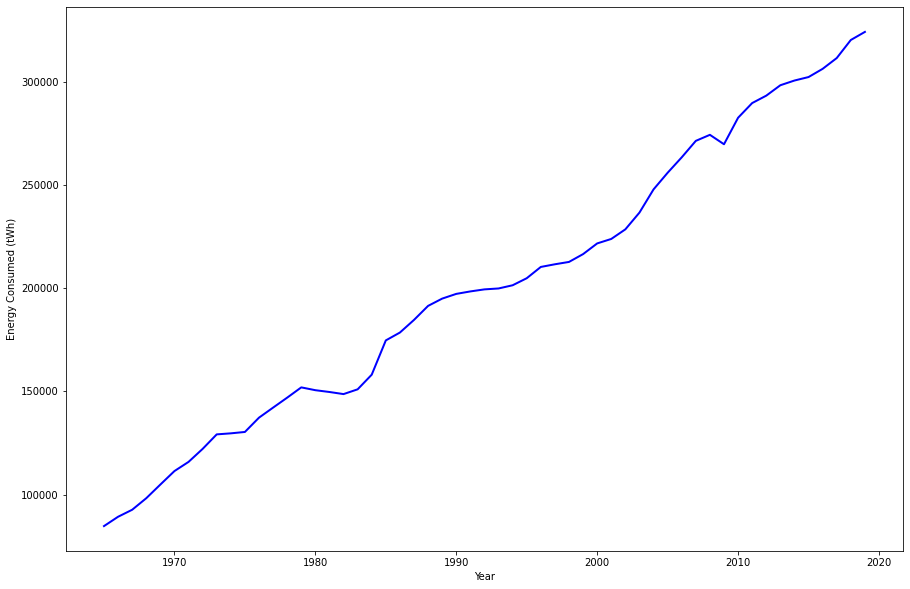

In [12]:
def totalConsumption(year):
    rawConsumptionData = pd.read_csv('Data/ConsumptionData')
    summedData = rawConsumptionData.where(rawConsumptionData["year"] == year).dropna().sum()
    del summedData["year"]
    del summedData["country"]
    return summedData.sum()
    
sumDict = dict()
for i in range(1965, 2020):
    sumDict[i] = totalConsumption(i)
    
plt.figure(figsize=(15,10))
plt.plot(sumDict.keys(), sumDict.values(), color="b", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Energy Consumed (tWh)")
plt.ticklabel_format(style='plain')
plt.show();

## Energy consumption increase per country
After finding out how the energy consumption increased over the years, we thought it would be interesting to check which countries had the largest increase. We found out that the top 3 countries are `United Arab Emirates`, `Qatar`, `Oman`.

In [17]:
def getTotalEnergyUsage(year, country):
    rawConsumptionData = pd.read_csv('Data/ConsumptionData')
    summedData = rawConsumptionData.where((rawConsumptionData["year"] == year) & (rawConsumptionData["country"] == country)).dropna().sum()
    del summedData["year"]
    del summedData["country"]
    return summedData.sum()

increases = dict()
index = 0
for c in countries:
    index += 1
    sums = []
    for y in range(1965, 2020):
        num = getTotalEnergyUsage(y, c)
        if num != 0:
            sums.append(num)
            
    if len(sums) < 5:
        continue
    
    percentages = []
    for i in range(len(sums)-1):
        percentages.append((sums[i+1] - sums[i]) / sums[i])
    increases[c] = np.mean(percentages)

In [18]:
print("%-25s"%"Counrty","Percent increase")
for x,y in Counter(increases).most_common(3):
    print("%-25s"%x,"%s%%"%round(y*100,1))

Counrty                   Percent increase
United Arab Emirates      20.8%
Qatar                     15.6%
Oman                      9.9%


## Renewable fuel popularity
The main point of this project was to find out if the popularity of renewable fuels has increase over time. We checked their usage for each year and found out that the popularity has increased by only by `1.8%` (from `2.7%` to `4.5%`)

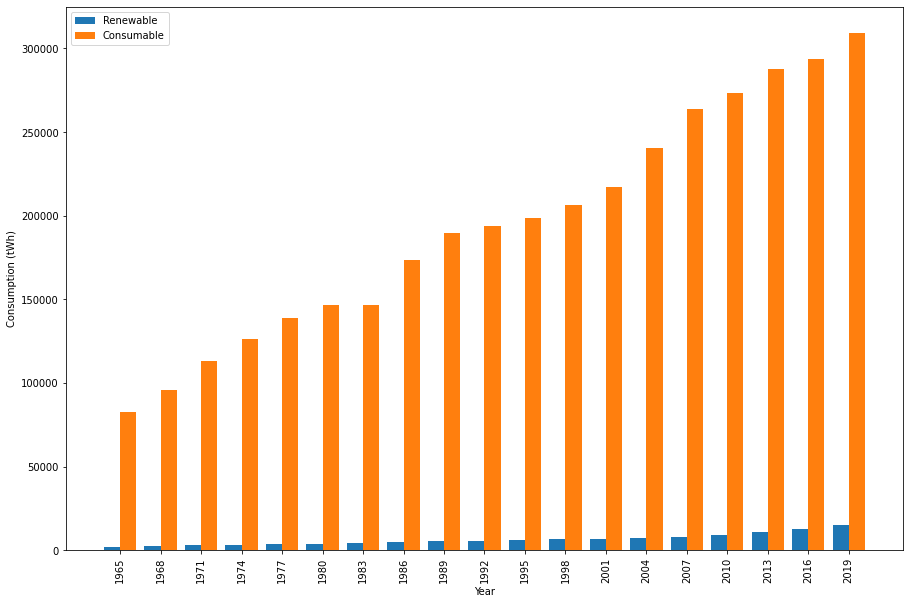

In [13]:
rawConsumptionData = pd.read_csv('Data/ConsumptionData')
years = range(1965, 2020, 3)
renewable = []
nonRenewable = []
for x in years:
    summedData = rawConsumptionData.where(rawConsumptionData["year"] == x).dropna().sum()
    del summedData["year"]
    del summedData["country"]
    renewable.append(summedData["hydro"] + summedData["solar"] + summedData["wind"])
    nonRenewable.append(summedData["biofuel"] + summedData["coal"] + summedData["fossil"] + summedData["gas"] + summedData["low_carbon"] + summedData["nuclear"] + summedData["oil"])

X_axis = np.arange(len(years))
plt.figure(figsize=(15, 10))
plt.bar(X_axis - 0.2, renewable, 0.4, label = 'Renewable')
plt.bar(X_axis + 0.2, nonRenewable, 0.4, label = 'Consumable')
plt.xticks(X_axis,years, rotation=90)
plt.xlabel("Year")
plt.ylabel("Consumption (tWh)")
plt.legend()
plt.show()

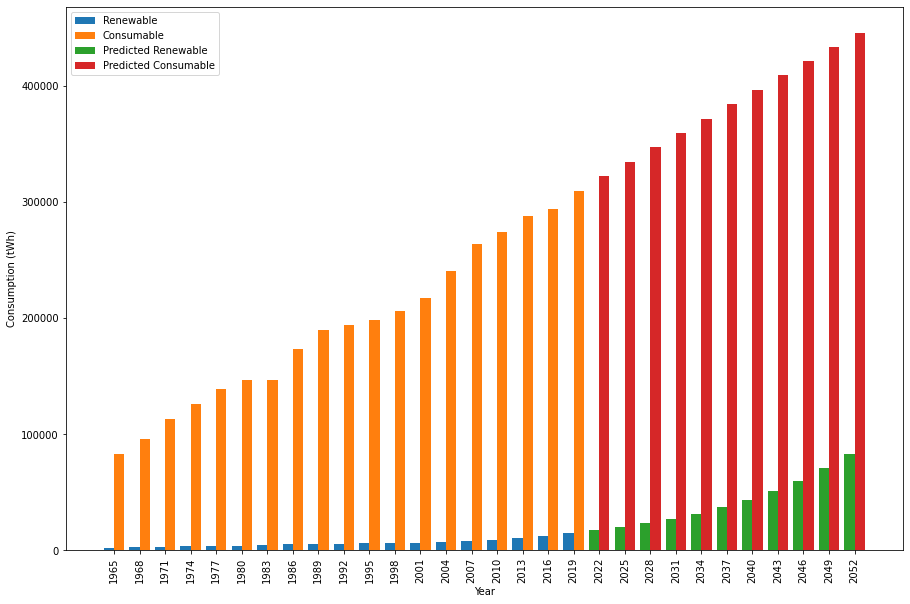

In [65]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(renewable, lags=1)
model_fit = model.fit()

modelNon = AutoReg(nonRenewable, lags=1)
modelNon_fit = modelNon.fit()

r=model_fit.predict(len(renewable), len(renewable) + 10)
nr=modelNon_fit.predict(len(nonRenewable), len(nonRenewable) + 10)

X_axis = np.arange(len(years))
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.bar(X_axis - 0.2, renewable, 0.4, label = 'Renewable')
ax.bar(X_axis + 0.2, nonRenewable, 0.4, label = 'Consumable')
X_axis1 = np.arange(len(years),len(years)+11)
ax.bar(X_axis1 - 0.2, list(r), 0.4, label = 'Predicted Renewable',)
ax.bar(X_axis1 + 0.2, list(nr), 0.4, label = 'Predicted Consumable')
plt.xlabel("Year")
plt.ylabel("Consumption (tWh)")
plt.xticks(np.arange(len(years)+11),range(1965, 2053, 3),rotation=90)
plt.legend()

plt.show();